# Week 6 Notebook 2 SDG Case Study

In this lesson, we will use the API provided by the [United Nations Statistics Division (UNSD)](https://unstats.un.org/home/).

You will use UNSD API to:
- send GET requests with a list of required countries as parameter values
- send POST requests to obtain a CSV file.

First, we must import the `requests` library.

In [ ]:
import requests

## The UNSD SDGs API

The UNStats.org Sustainable Development Goals API is available here: https://unstats.un.org/SDGAPI/swagger/.
You can see that some API endpoints are listed as POST and some as GET.
We already learn on how to use the GET requests, so let's try that first. 

### Getting the List of Goals

The first API endpoint we want to try is to get the list of goals.

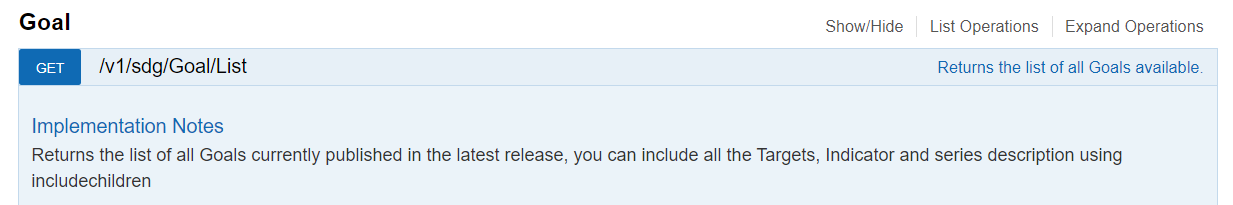

The Base URL is `http://unstats.un.org/SDGAPI`and the endpoint is `/v1/sdg/Goal/List`.

In [ ]:
# Return a list of all Goals in the latest release
goals = requests.get("https://unstats.un.org/SDGAPI/v1/sdg/Goal/List")
print(goals.status_code )

**Decoding JSON**

Since the status code is `200`, let's decode the content.

In [ ]:
goalsData = goals.json()
print(goalsData)

**Neatly Print the Goals List**

We can see the data is returned as a list of dictionaries, so let's print a list of each goal using the `title` key.

In [ ]:
# Print each goal's code and title
for goal in goalsData:
    print(goal['code'], goal['title'])

### Get Indicators and Data Series

For each goal, there is a list of targets. There are specific indicators defined for the targets that should be tracked by the various UN member countries. 

For each indicator, there is one or more data series that are used to reflect the indicator. This is what we are interested in.
Some series can be used for more than one goal or indicator. 

Let's try to get the indicators and the series for one of the goals using the endpoint `/v1/sdg/Indicator/List`.
You can change the required goal to another number between 1 and 17 as in the list above.

In [ ]:
response = requests.get("https://unstats.un.org/SDGAPI/v1/sdg/Indicator/List")
indicatorlist = response.json()

# You can change the goal number between 1 to 17
requiredGoal = '1'

# Show indicators for this goal
for indicator in indicatorlist:
    if indicator['goal']==requiredGoal:
        print('\n',indicator['code'], indicator['description'])
    
        # Show data series for this indicator
        indicatorSeries = indicator['series']
        for series in indicatorSeries:
            print(series['code'], series['description'])

### Getting the list of Countries

Another API we can use is to get the list of countries. This is because each country has a **geoAreaCode** that can be used as the parameter value when getting data. Since there are so many countries, for this notebook we will only focus on some Asian countries and Australia, for comparison.

The endpoint for the GeoAreas is `/v1/sdg/GeoArea/List`.

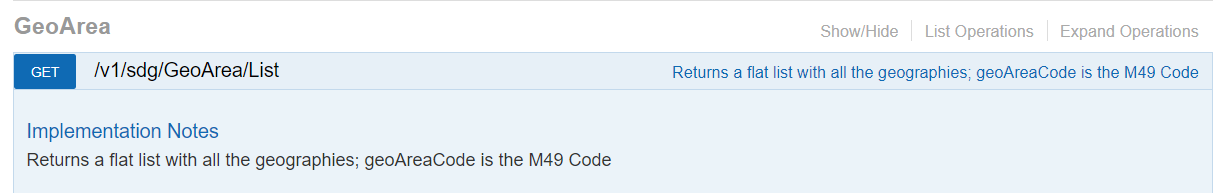



In [ ]:
# Get a flat list with all the geographies
regionsList = requests.get("https://unstats.un.org/SDGAPI/v1/sdg/GeoArea/List")
regionsData = regionsList.json()
for region in regionsData:
    print(region['geoAreaCode'], region['geoAreaName'])

**Store a List of Country geoAreaCodes**

We can see that some `geoAreaCodes` represents not only countries, but also regions. We want to select particular Asian countries, so we will find all the `geoAreaCodes` for the countries that we are interested in and store them in a list.

In [ ]:
# Prepare list of required countries for comparison
# you can add or remove countries as you wish
countriesWanted = ['Australia','Bangladesh','Cambodia','China','India',
                   'Indonesia','Japan','Malaysia','Philippines','Singapore',
                   'Sri Lanka','Thailand','Viet Nam']
countryCodes = []
regionsListData = regionsList.json()
for region in regionsListData:
    if region['geoAreaName'] in countriesWanted:
        countryCodes.append(region['geoAreaCode'])
print(countryCodes)

**Getting Data**

Now that we have the list of countries that we want and the series codes for the required goal, we can form our parameters in a `payload` and send another request to get data for the series.

For example, to get the data for the series 'SI_POV_EMP1', the "Employed population below international poverty line, by sex and age (%)":

In [ ]:
# Get the data for the defined series
# you can change the series code
payload ={'seriesCode':'SI_POV_EMP1', 'areaCode':countryCodes}
poverty = requests.get("https://unstats.un.org/SDGAPI/v1/sdg/Series/Data", params= payload)

# Decode and display the result
povertyDict = poverty.json()
povertyDict

**Check Returned Data**

We can see that the dictionary keys are `size`, `totalElements`, `totalPages`, `pageNumber`, `attributes` and `data`. From the values of the `totalPages` and `pageNumber`, we can see that this is page number 1 out of 63 pages.

In [ ]:
print('Page number :', povertyDict['pageNumber'])
print('Total Pages :', povertyDict['totalPages'])

**Show the Data**

Let's use a `for` loop to go through values with the `data` key.

In [ ]:
# Extract the values from the 'data' key
countryData = povertyDict['data']
for item in countryData:
    print(item['geoAreaName'], item['series'], item['timePeriodStart'], item['value'], item['dimensions'])

There is only one country shown, but as we noticed this was only page number 1 out of 63 pages. We could send requests again in a loop using the number of pages as the loop range. However, there might be a better API endpoint that we can use.

## Post Request API

A POST request is another type of API request. 

The difference between a GET request and a POST request is that GET request is usually to retrieve resources, while POST request is usually used to create or upload data resources. Furthermore, the keyword argument for request parameters is different:
- in POST request, we use keyword argument `data`
- in GET request, we use the keyword argument `params`.

Another API endpoint for retrieving the data series is `/v1/sdg/Series/DataCSV`, which returns a CSV file.

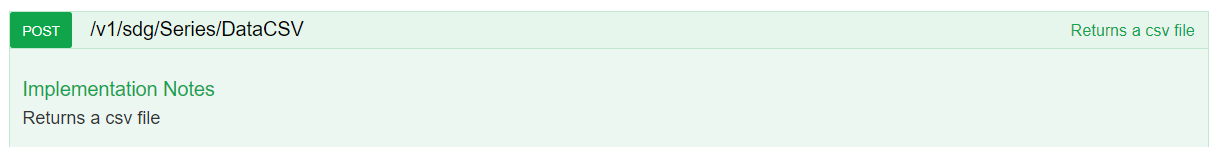

Let's send the POST request using the same payload.

In [ ]:
# Use the same payload to get a CSV file using POST request  
payload = {'seriesCodes':'SI_POV_EMP1','areaCodes':countryCodes}

# Pass the parameters using the 'data='' keyword argument
seriesData = requests.post("https://unstats.un.org/SDGAPI/v1/sdg/Series/DataCSV", data=payload)
print(seriesData.status_code)
print(seriesData.headers)

**Saving the CSV file**

If we look at the content type in the response `headers`, you will see that the response type is `application/octet-stream`. It means that the response is in binary format, not the usual JSON format. 

Since we know it is a CSV file, we can save it using our file handling techniques from Week 2.

In [ ]:
# Write the CSV content into a file
povertyFile = open('poverty.csv', 'wb')      # open a file for writing, in binary format
povertyFile.write(seriesData.content)        # write the content to the file
povertyFile.close()                          # close the file properly

**Exploring the Data with Pandas**

Now that the file has been saved to our directory, we can view it using Microsoft Excel or even a notepad. 
However, we can also use Pandas to explore the data by loading it back in as a `DataFrame` object.

In [ ]:
import pandas as pd

povertyData = pd.read_csv('poverty.csv')
povertyData.head()

In [ ]:
# Check DataFrame info
povertyData.info()

**Missing Value Treatment** 

Looks like we have to do some data cleaning on the missing/null values. From the `info()` method above, we can see that the `TimeCoverage`, `UpperBound`, `LowerBound`, `BasePeriod`, `GeoInfoUrl` and `FootNote` columns have null values. We can also count the number of null values for each column.

In [ ]:
# Count number of missing values for each column
povertyData.isnull().sum()

Out of 1567 entries, there are 1567 values for `TimeCoverage`, `UpperBound`, `LowerBound`, `BasePeriod`, `GeoInfoUrl` and `FootNote` columns. This means these values are all null.

There is also one null value for each of the other columns. Let's drop all rows that contain missing value and drop all columns that all of its value is missing.

In [ ]:
# Drop Null values for axis=1, how='all' means drop the columns with ALL null values
povertyData.dropna(axis=1, how="all", inplace=True)

# Now drop all rows with ALL null values
povertyData.dropna(axis=0, how="all", inplace=True)

povertyData.info()

**Converting Data Types**

Let's convert the `TimePeriod`column data type into integer rather than float.

In [ ]:
# Convert the 'TimePeriod' column data type
povertyData['TimePeriod'] = povertyData['TimePeriod'].astype(int)

**Check Category Levels**

We also want to check the number of values for each of the categories of interest.

In [ ]:
print(povertyData['GeoAreaName'].value_counts())
print(povertyData['TimePeriod'].value_counts())
print(povertyData['[Age]'].value_counts())
print(povertyData['[Sex]'].value_counts())

**Renaming Columns**

We might want to rename some columns, so that it is clearer and easier for us to use. Let's rename:
- `GeoAreaName` as `Country`
- `TimePeriod` as `Year`
- Columns with square brackets `[]` around its name

In [ ]:
# Rename the columns, inplace
povertyData.rename(columns={'GeoAreaName':'Country', 'TimePeriod':'Year', '[Age]':'Age', '[Sex]':'Sex'}, inplace=True)
povertyData.head()

**Separating the Data**

Looking at the data values, we can see that some of it would be redundant, such as:
- the `Age` of 15+ encompasses both 15 - 24 and 25+
- BOTHSEX encompasses both FEMALE and MALE.

So, we should decide which data we want to include for analysis.

Let's separate it into 2 data sets:
- one with the combined data for 15+ and BOTHSEX
- one with the breakdown by age and SEX.

We can do this with pandas by defining two separate data sets:
- combined data where the `[Age]` value is '15+' and `[Sex]` value is 'BOTHSEX'
- the detailed data where it does not fit the criteria for the combined data.

In [ ]:
# Separate into two data sets
combinedData = povertyData[(povertyData['Age']=='15+') & (povertyData['Sex']=='BOTHSEX')]
detailedData = povertyData[(povertyData['Age']!='15+') & (povertyData['Sex']!='BOTHSEX')]

Let's check what the two data sets look like. We did not change all the column names, but you may rename it if you want.

In [ ]:
combinedData.head()

In [ ]:
detailedData.head()

**Plotting**

Let's plot the data using Matplotlib library. We can use the `combinedData` to compare the data values over time for the different countries.

In [ ]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the 'combinedData'
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(data=combinedData, x='Year', y='Value', hue='Country', marker='o', alpha=0.5, palette='bright')
plt.legend(bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.set_title("ILO Modelled Estimates of Employed Population Below International Poverty Line, %")
plt.show()

For the `detailedData`, we could create subplots or facets to compare them better.

In [ ]:
# Use FacetGrid to compare countries, Employee Age Range and Sex
g = sns.FacetGrid(data = detailedData, row='Country', col='Age', hue='Sex',  margin_titles=True)
g.map(sns.lineplot, 'Year', 'Value',alpha=0.5)
g.set_axis_labels("Year", "% Below Poverty Line")
g.set_titles(col_template="Employee Age Range : {col_name}", row_template="{row_name}")
g.add_legend()
g.fig.suptitle('ILO Modelled Estimates of Employed Population Below International Poverty Line, %')
g.fig.subplots_adjust(top=0.95)

You can try to plot other data or use a different indicator with the above code.

Always check the data that is returned from the API and consider how it has been arranged and what the values mean.

## Exercises

Let's try to get data for different goal. For example 'Goal 4: Ensure inclusive and equitable quality education and promote lifelong learning opportunities for all'.

**Q1 Get Series for Goal 4**

Using the `https://unstats.un.org/SDGAPI/v1/sdg/Indicator/List` API endpoint, show the series list for this Goal!

In [ ]:
# Q1 Answer


**Q2 Get CSV File**

Let's use the 'Indicator 4.4.1 Proportion of youth and adults with information and communications technology (ICT) skills', by `[Type of skill]`.
- What is the series code?
- Use the same country codes as before!

Send a POST request to retrieve the CSV data.

In [ ]:
# Q2 Answer



**Q3 Save the CSV Data**

Save the data into a file titled 'ictSkills.csv'!

In [ ]:
# Q3 Answer


**Q4 Read from a File using Pandas**

Load the CSV file into a DataFrame called `ictSkillsData` and view it!

In [ ]:
#Q4 Answer


**Q5 Drop Missing Values**

Drop the missing values for the rows and columns which contain ALL `null` values!

In [ ]:
# Q5 Answer 


**Q6 Get Value Counts**

Check the value counts for the `TimePeriod`, `[Sex]`, `[Type of skill]` and `GeoAreaNames` columns.

In [ ]:
#Q6 Answer 


**Q7 Filter the Data**

Create a subset that includes data only for the last 3 years with `[Sex]`value of either 'MALE' or 'FEMALE'!

In [ ]:
# Q7  Answer


**Q8 Plot the Data**

Create a barplot to compare the proportion of youths in `ictSkills` by country, `[Type of skill]` and `[Sex]`. 

Example: Using a facetgrid with showing barplots of value by `Sex`
- column = `GeoAreaName`
- row = `Type of Skill`
- hue = `Sex`

In [ ]:
# Q8 Answer


**Note: Identifying 'Type of skill'**

The description of the `[Type of skill]` can be found in the series dimension. 

You can use the `https://unstats.un.org/SDGAPI/v1/sdg/Series/Data` API endpoint with the series code and any country code as the parameters to view the series dimension.

In [ ]:
# Get the data for the defined series
# you can change the series code
payload ={'seriesCode':'SE_ADT_ACTS', 'areaCode':'458'}
response = requests.get("https://unstats.un.org/SDGAPI/v1/sdg/Series/Data", params= payload)
seriesInfo = response.json()

In [ ]:
for dim in seriesInfo['dimensions']:
    if (dim['id']=='Type of skill'):
        skillcodes = dim['codes']

In [ ]:
# Now you can use these as a reference in to the plot.
for skill in skillcodes:
    print(skill['code'], skill['description'])